In [252]:
import numpy as np
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.layers import Dense, BatchNormalization
from keras import Sequential
import seaborn as sns
from sklearn import metrics



class StripTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = X[column].map(lambda x: str(x).lstrip('XC'))
        return X


def check_for_14_p(y):
    print(y)
    if y == "14+":
        return "15"
    return y


class Make14PTo15Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = X[column].map(lambda x: x if x != "14+" else "15")
            return X

Your Client FinMan is a financial services company that provides various financial services like loan, investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

## Erstelle aus `health-insurance.csv` einen DataFrame

In [253]:
insurance = pd.read_csv('./data/health-insurance.csv')
insurance["Health_Indicator"] = insurance["Health Indicator"]
insurance = insurance.drop(columns="Health Indicator")
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Holding_Policy_Duration  30631 non-null  object 
 9   Holding_Policy_Type      30631 non-null  float64
 10  Reco_Policy_Cat          50882 non-null  int64  
 11  Reco_Policy_Premium      50882 non-null  float64
 12  Response                 50882 non-null  int64  
 13  Health_Indicator         39191 non-null  object 
dtypes: float64(2), int64(6

## Data Cleaning

* fehlende `Holding_Policy_Duration`/`Holding_Policy_Duration`-Werte sind gleich viele, sollten also gleich behandelt werden
* betrachte die Ausprägungen von `Health Indicator`. Auch hier gibt es einige `NaN`s

In [254]:
columnTransformer = ColumnTransformer(
    transformers=[("oneHotEncoder", OneHotEncoder(), ["Is_Spouse", "Reco_Insurance_Type", "Accomodation_Type"]),
                  ("stripTransformer", StripTransformer(columns=["Health_Indicator", "City_Code"]), ["Health_Indicator", "City_Code"]),
                  ("make14PTo15Transformer", Make14PTo15Transformer(columns=["Holding_Policy_Duration"]), ["Holding_Policy_Duration"])
                  ],
    remainder="passthrough")

pipe = Pipeline([("transformers", columnTransformer),
                 ("imputer", IterativeImputer()),
                 ("scalar", RobustScaler())
                 ])

## Training
* 20% Testdaten
* `random_state=42` sofern unterstützt
* target feature: `Response`
* Überlege, welche Metrik maximiert werden soll (*accuracy*/*recall*/*f1*) und was die Business Implikation des erhaltenen Modells ist, diese Metrik geht in die `GridSearchCV` als `scoring` ein
* Trainiere mindestens
    * eine optimierte `LogisticRegression` mit `GridSearchCV` (optimiere `solver`, `C` und `class_weight`)
    * einen optimierten `KNeighborsClassifier` mit `GridSearchCV` (optimiere `n_neighbors` und `weights`)
    * zwei ANNs (eins mit `class_weights` und eins ohne).
        `compile(metrics=[<metrik>]` kann entweder ein String übergeben werden oder eine Instanz einer Klasse aus `keras.metrics`

In [255]:
X = insurance.drop(columns="Response")
y = insurance.Response

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 ,random_state=42)

X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)


### LogisticRegression

In [256]:

log_cv = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid= {
        "solver": ['sag', 'saga', 'newton-cg', 'lbfgs'],
        'class_weight': [None, 'balanced'],
        'C': [1, 0.1, 10, 0.01, 10, 0.001]
    },
    n_jobs=20,
    scoring="precision",
    cv=5
)

log_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=20,
             param_grid={'C': [1, 0.1, 10, 0.01, 10, 0.001],
                         'class_weight': [None, 'balanced'],
                         'solver': ['sag', 'saga', 'newton-cg', 'lbfgs']},
             scoring='precision')

In [257]:
log_cv.best_estimator_.score(X_test, y_test)

0.4760734990665226

In [258]:
print(classification_report(y_test, log_cv.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.42      0.55      7688
           1       0.27      0.66      0.38      2489

    accuracy                           0.48     10177
   macro avg       0.53      0.54      0.46     10177
weighted avg       0.66      0.48      0.51     10177



### ANN ohne Class Weight

In [259]:
cb_early_stop = EarlyStopping(
    monitor='val_precision',
    min_delta=0.05,
    patience=10,
    restore_best_weights=True,
    verbose=1)

Epoch 1/30
1273/1273 [==============================] - 3s 2ms/step - loss: 0.5657 - precision: 0.2498 - val_loss: 0.5495 - val_precision: 0.0000e+00
Epoch 2/30
1273/1273 [==============================] - 2s 2ms/step - loss: 0.5440 - precision: 0.3600 - val_loss: 0.5521 - val_precision: 0.0000e+00
Epoch 3/30
1273/1273 [==============================] - 2s 2ms/step - loss: 0.5421 - precision: 0.2500 - val_loss: 0.5476 - val_precision: 0.0000e+00
Epoch 4/30
1273/1273 [==============================] - 2s 2ms/step - loss: 0.5403 - precision: 0.5000 - val_loss: 0.5490 - val_precision: 0.0000e+00
Epoch 5/30
1273/1273 [==============================] - 2s 2ms/step - loss: 0.5400 - precision: 0.0000e+00 - val_loss: 0.5473 - val_precision: 0.0000e+00
Epoch 6/30
1273/1273 [==============================] - 2s 2ms/step - loss: 0.5394 - precision: 0.0000e+00 - val_loss: 0.5482 - val_precision: 0.0000e+00
Epoch 7/30
1273/1273 [==============================] - 2s 2ms/step - loss: 0.5383 - precisi

<AxesSubplot: >

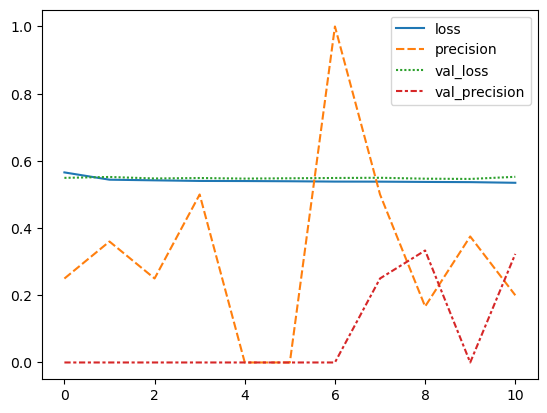

In [261]:
ann_wo_cw = Sequential([
    Dense(units=50, activation='relu'),
    BatchNormalization(),
    Dense(units=50, activation='relu'),
    BatchNormalization(),
    Dense(units=50, activation='relu'),
    BatchNormalization(),
    Dense(units=50, activation='relu'),
    BatchNormalization(),
    Dense(units=1, activation='sigmoid')
])
ann_wo_cw.compile(optimizer='adam', loss='binary_crossentropy', metrics=keras.metrics.Precision(name='precision'))
history = ann_wo_cw.fit(X_train, y_train,
                        callbacks=cb_early_stop,
                        validation_data=(X_test, y_test),
                        epochs=30,
                        workers=-1,
                        verbose=1
                        )
history = pd.DataFrame(history.history)
sns.lineplot(data=history)

In [262]:
print(confusion_matrix(y_test, (ann_wo_cw.predict(X_test) > 0.5).astype("int32")))
print(classification_report(y_test, (ann_wo_cw.predict(X_test) > 0.5).astype("int32")))

319/319 [==============================] - 0s 670us/step
[[7688    0]
 [2489    0]]
319/319 [==============================] - 0s 689us/step
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7688
           1       0.00      0.00      0.00      2489

    accuracy                           0.76     10177
   macro avg       0.38      0.50      0.43     10177
weighted avg       0.57      0.76      0.65     10177



C:\Users\longb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\longb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\longb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### ANN mit Class Weights

In [263]:
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y= y_train)))
class_weights

{0: 0.6568500887526222, 1: 2.093878600823045}

Epoch 1/30
1273/1273 [==============================] - 4s 3ms/step - loss: 0.7131 - precision: 0.2585 - val_loss: 0.6960 - val_precision: 0.2684
Epoch 2/30
1273/1273 [==============================] - 3s 3ms/step - loss: 0.6852 - precision: 0.2675 - val_loss: 0.6946 - val_precision: 0.2698
Epoch 3/30
1273/1273 [==============================] - 3s 2ms/step - loss: 0.6842 - precision: 0.2650 - val_loss: 0.6829 - val_precision: 0.2726
Epoch 4/30
1273/1273 [==============================] - 4s 3ms/step - loss: 0.6822 - precision: 0.2618 - val_loss: 0.6712 - val_precision: 0.2649
Epoch 5/30
1273/1273 [==============================] - 3s 2ms/step - loss: 0.6814 - precision: 0.2643 - val_loss: 0.6746 - val_precision: 0.2723
Epoch 6/30
1273/1273 [==============================] - 3s 3ms/step - loss: 0.6790 - precision: 0.2699 - val_loss: 0.6767 - val_precision: 0.2733
Epoch 7/30
1273/1273 [==============================] - 4s 3ms/step - loss: 0.6793 - precision: 0.2670 - val_loss: 0.6606 - 

<AxesSubplot: >

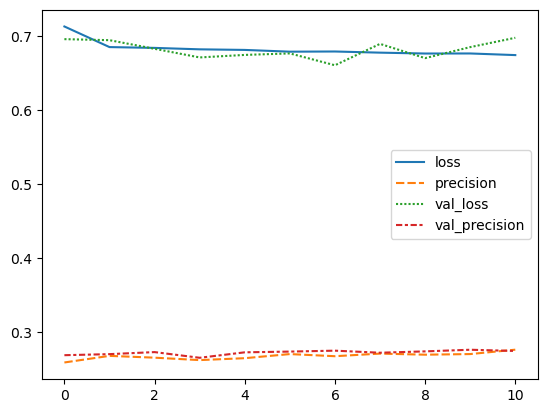

In [246]:
ann_classweights = Sequential([
    Dense(units=800, activation='relu'),
    BatchNormalization(),
    Dense(units=800, activation='relu'),
    BatchNormalization(),
    Dense(units=200, activation='relu'),
    BatchNormalization(),
    Dense(units=1, activation='sigmoid')
])
ann_classweights.compile(optimizer='adam', loss='binary_crossentropy', metrics=keras.metrics.Precision(name='precision'))
history = ann_classweights.fit(X_train, y_train,
                               callbacks=cb_early_stop,
                               validation_data=(X_test, y_test),
                               epochs=30,
                               workers=-1,
                               verbose=1,
                               class_weight=class_weights,
                               )
history = pd.DataFrame(history.history)
sns.lineplot(data=history)

In [247]:
print(metrics.classification_report(y_test, (ann_classweights.predict(X_test) > 0.5).astype("int32")))

319/319 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.79      0.46      0.58      7688
           1       0.27      0.61      0.37      2489

    accuracy                           0.50     10177
   macro avg       0.53      0.54      0.48     10177
weighted avg       0.66      0.50      0.53     10177



## Evaluiere die Modelle und Interpretiere deine Lösung bezüglich *precision*/*recall*/*f1*

### Beste precision gibt ANN mit class weights